In [ ]:
# sudo apt install opus-tools
# opusdec --quiet --rate 16000 1.ogg 1.wav
# opusenc --quiet 1.wav x.ogg

In [60]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt

In [61]:
args = ['opusdec', '--quiet', '--rate', str(16000), '1.ogg', '-']
audio = np.frombuffer(subprocess.check_output(args), dtype=np.int16)

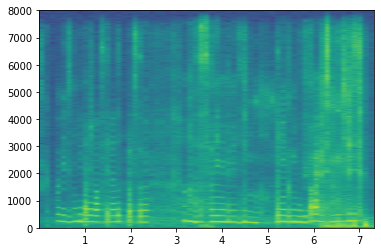

In [212]:
plt.specgram(audio, Fs=16000, NFFT=2048, noverlap=128); # cmap=plt.get_cmap('magma') magma, plasma, inferno

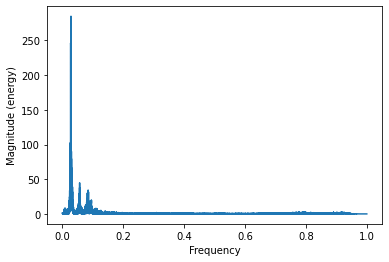

In [101]:
plt.magnitude_spectrum(audio);

In [132]:
import essentia
import essentia.standard
w = essentia.standard.Windowing(type='hann')
spectrum = essentia.standard.Spectrum()
mfcc = essentia.standard.MFCC()
logNorm = essentia.standard.UnaryOperator(type='log')
spec = spectrum(w(essentia.array(audio)))

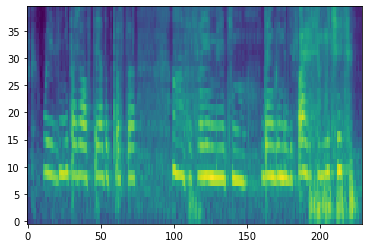

In [151]:
mfccs = []
melbands = []
melbands_log = []

for frame in essentia.standard.FrameGenerator(essentia.array(audio), frameSize=1024, hopSize=512, startFromZero=True):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
    mfccs.append(mfcc_coeffs)
    melbands.append(mfcc_bands)
    melbands_log.append(logNorm(mfcc_bands))

mfccs = essentia.array(mfccs).T
melbands = essentia.array(melbands).T
melbands_log = essentia.array(melbands_log).T

plt.imshow(melbands_log[:,:], aspect = 'auto', origin='lower', interpolation='none');

/home/vaaliferov/github/dev/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


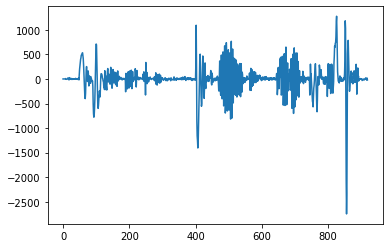

In [181]:
import scipy.signal as signal

f, t, Zxx = signal.stft(audio, fs=16000)

#plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=100);

plt.plot(Zxx[5]);

In [186]:
import numpy as np
import numpy.fft as fft

def stft(x, Nwin, Nfft=None):
    Nfft = Nfft or Nwin
    Nwindows = x.size // Nwin
    arr = np.reshape(x[:Nwindows * Nwin], (-1, Nwin))
    stft = fft.rfft(arr, Nfft)
    return stft

def stftbins(x, Nwin, Nfft=None, d=1.0):
    Nfft = Nfft or Nwin
    Nwindows = x.size // Nwin
    t = np.arange(Nwindows) * (Nwin * d)
    f = fft.rfftfreq(Nfft, d)
    return t, f

s = stft(audio, 64, Nfft=128)
t, f = stftbins(audio, 64, Nfft=128, d=1 / 16000)

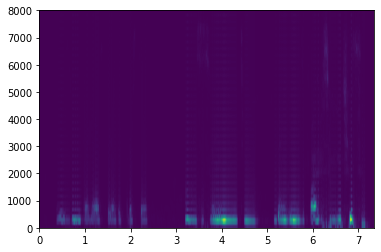

In [207]:
plt.imshow(np.abs(s).T, origin='lower', aspect="auto", extent=[t[0], t[-1], f[0], f[-1]]);

In [ ]:
import math
import subprocess
import numpy as np
import telegram.ext
from config import *
import matplotlib.pyplot as plt

SR = 16000
source, shadow = {}, {}

def load_voice(context, file_id):
    context.bot.getFile(file_id).download('a.ogg')
    args = ['opusdec', '--quiet', '--rate', str(SR), 'a.ogg', '-']
    return np.frombuffer(subprocess.check_output(args), dtype=np.int16)

def send_voice(context, chat_id, audio, caption=''):
    args = ['opusenc', '--quiet', '--raw-chan', '1', 
            '--raw-rate', str(SR), '-', 'a.ogg']
    subprocess.check_output(args, input=audio.tobytes())
    with open('a.ogg', 'rb') as fd:
        context.bot.send_voice(chat_id, fd, caption=caption)

def split_audio(audio, n_secs=2):
    n_pieces = math.ceil(len(audio) / (n_secs * SR))
    return np.array_split(audio, n_pieces)        

def send_plot(context, chat_id, audio, caption=''):
    fig, ax = plt.subplots(); fig.set_size_inches(6,3)
    ax.plot(audio); fig.savefig('p.jpg'); plt.close(fig)
    with open('p.jpg', 'rb') as fd:
        context.bot.send_photo(chat_id, fd, caption=caption)

def handle_voice(update, context):

    user = update.message.from_user
    file_id = update.message.voice['file_id']
    audio = load_voice(context, file_id)
    
    if user['id'] != TG_BOT_OWNER_ID:
        msg = f"@{user['username']} {user['id']}"
        context.bot.send_message(TG_BOT_OWNER_ID, msg)
        context.bot.send_voice(TG_BOT_OWNER_ID, file_id)
    
    if user['id'] not in source:
        source[user['id']] = split_audio(audio[::-1])
        send_plot(context, user['id'], audio)
        send_voice(context, user['id'], audio[::-1], 'reversed')
        shadow[user['id']] = []
        
    else:
        shadow[user['id']].append(audio)
    
    if len(shadow[user['id']]) < len(source[user['id']]):
        part = f"part #{len(shadow[user['id']]) + 1}"
        audio = source[user['id']][len(shadow[user['id']])]
        send_voice(context, user['id'], audio, part)
        
    else:
        audio = np.concatenate(shadow[user['id']])[::-1]
        send_voice(context, user['id'], audio, 'done!')
        del source[user['id']], shadow[user['id']]

h = telegram.ext.MessageHandler
vf = telegram.ext.Filters.voice 
u = telegram.ext.Updater(TG_BOT_TOKEN)
u.dispatcher.add_handler(h(vf, handle_voice))
u.start_polling(); u.idle()

In [ ]:
import subprocess
import numpy as np

def opus_read_(path):
    subprocess.call(['opusdec', '--quiet', '--rate', '16000', path, 'out.wav'])
    return soundfile.read('out.wav')[0]

def opus_write_(path, audio):
    soundfile.write('out.wav', audio, 16000)
    subprocess.call(['opusenc', '--quiet', 'out.wav', path])

def opus_read(path):
    args = ['opusdec', '--quiet', '--rate', '16000', path, '-']
    return np.frombuffer(subprocess.check_output(args), dtype=np.int16)

def opus_write(path, audio):
    args = ['opusenc', '--quiet', '--raw-chan', '1', '--raw-rate', '16000', '-', path]
    subprocess.check_output(args, input=audio.tobytes())
    
def send_spec(context, chat_id, audio, caption=''):
    params = {'sr': SR, 'n_mels': 128, 'fmin': 1, 'fmax': 8192}
    spec = librosa.feature.melspectrogram(audio, **params)
    spec = librosa.power_to_db(spec, ref=np.max)
    spec = (spec - spec.min()) / (spec.max() - spec.min())
    fig, ax = plt.subplots(); fig.set_size_inches(6,3)
    ax.imshow(spec, origin='lower'); 
    fig.savefig('p.jpg'); plt.close(fig)
    with open('p.jpg', 'rb') as fd:
        context.bot.send_photo(chat_id, fd, caption=caption)

In [ ]:
import math
import librosa
import soundfile
import numpy as np
import telegram.ext
from config import *
import matplotlib.pyplot as plt

In [8]:
numba.__version__, numpy.__version__

('0.54.1', '1.20.3')

In [ ]:
!pip3 install --upgrade librosa

In [137]:
import math
import librosa
import IPython
import numpy as np
import matplotlib.pyplot as plt

In [101]:
audio, sr = librosa.load('2.ogg')
audio = librosa.resample(audio, sr, 16000)
IPython.display.Audio(audio[::-1], rate=16000)

/home/vaaliferov/github/dev/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


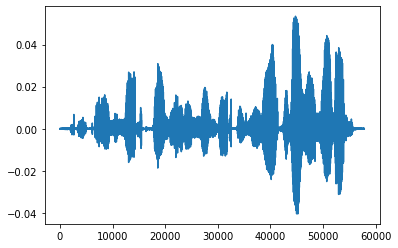

In [105]:
plt.plot(audio[::-1]);

In [154]:
n = math.ceil(len(audio) / (2 * 16000))
data = np.array_split(audio[::-1], n)
[len(x) for x in data]

[28929, 28928]

In [156]:
IPython.display.Audio(data[0], rate=16000)

In [102]:
def get_spec(audio):
    params = {'sr': 16000, 'n_mels': 128, 'fmin': 1, 'fmax': 8192}
    spec = librosa.feature.melspectrogram(audio, **params)
    spec = librosa.power_to_db(spec, ref=np.max)
    spec = 255 * (spec - spec.min()) / (spec.max() - spec.min())
    return spec.astype(np.uint8)

def plot_spec(spec, path):
    fig, ax = plt.subplots()
    fig.set_size_inches(6,3)
    ax.imshow(spec.T, origin='lower') # aspect='auto'
    fig.savefig(path)
    plt.close(fig)

def plot_audio(audio, path):
    fig, ax = plt.subplots()
    fig.set_size_inches(6,3)
    ax.plot(audio)
    fig.savefig(path)
    plt.close(fig)

In [92]:
plot_audio(audio, 'in.jpg')

In [93]:
plot_audio(audio[::-1], 'in.jpg')

In [100]:
spec = get_spec(audio); plot_spec(spec, 'spec.jpg')